In [1]:
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras import layers, callbacks

from keras.utils import to_categorical

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot

from scipy.stats import norm
from scipy import stats
import os

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import dataframe_image as dfi
import pickle
import math

In [2]:
channel_width = 79
time_data_amount = 10
nr_classes = 3

using_weights = False

#### Save parameters

In [3]:
name = 'All_channels_test' #name of model - should be descriptive
save_folder = 'template_' + str(time_data_amount) #hyperparameter description her
if using_weights == True:
    save_folder = save_folder + '_W'
    name = name + '_weighted'

### Gotta load in some data

In [4]:
datapath = '../../../All generated data/'
labelpath = '../../../All generated labels/'
data_list = os.listdir(datapath)
#print(data_list)

#all_data = [] #if we want to have data and labels in one list
all_datapoints = []
all_labels = []

total_channels = 79
total_scans_pr_sample = 20


for csv_file in data_list:
    data_file = datapath + csv_file
    current_data_file = pd.read_csv(data_file,header=None)

    label_file = labelpath + csv_file
    label_file = label_file.replace('.csv', '_labels.csv')
    current_label_file = pd.read_csv(label_file,header=None)

    for data_iter in range(len(current_data_file.index)):
        #Pulling out the data from a row and putting it in the list
        current_data_point = np.array(current_data_file.iloc[data_iter])
        current_data_point = current_data_point.reshape(total_scans_pr_sample,total_channels)
        all_datapoints.append(current_data_point)
        
        #adding the label to the datamatrix as the last row
        label_row = np.array(current_label_file.iloc[data_iter])
        label_row = label_row.reshape(1,total_channels)
        all_labels.append(label_row)
        
        #all_data.append(np.vstack([current_data_point, label_row])) #if we want to have data and labels in one list


In [5]:
print(all_labels[1].shape)
print(len(all_labels))
print(len(all_datapoints))

(1, 79)
10981
10981


#### Pick out one channel for each sample
For now it takes the same channel for all samples

In [6]:
complete_data = []
complete_labels = []


for iter in range(len(all_datapoints)):
    complete_data.append(all_datapoints[iter][0:time_data_amount,:])
    complete_labels.append(all_labels[iter][:,:])
    

#quick check to make sure it works
print(complete_data[1].shape)
print(len(complete_data))
print(complete_labels[1].shape)
print(len(complete_labels))


(10, 79)
10981
(1, 79)
10981


### Print some random samples to check validity

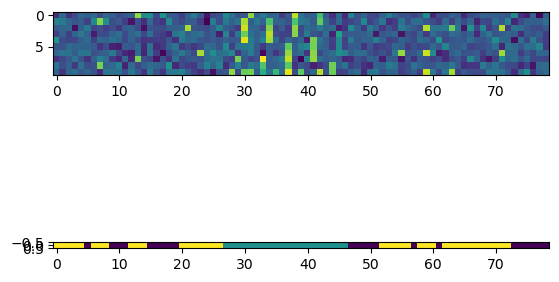

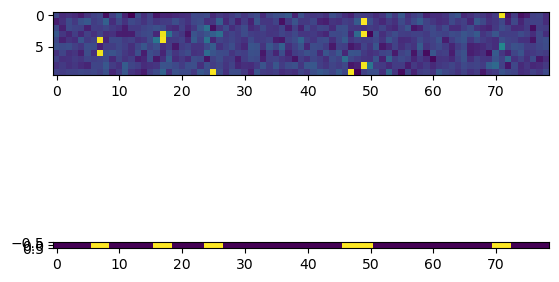

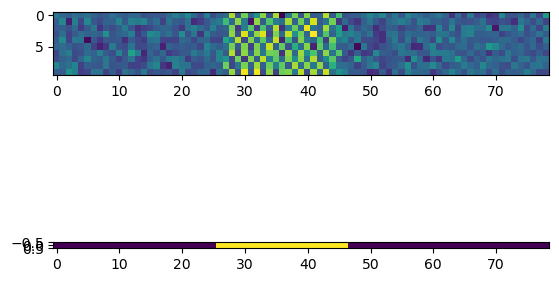

In [7]:
listNumbers = [150,204,420]

for af in listNumbers:
    figure, axis = plt.subplots(2,1)
    axis[0].imshow(complete_data[af])

    axis[1].imshow(complete_labels[af])
    plt.show()



### Class weigths

In [8]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = preprocessing.MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))
  

def weighted_mean_squared_error(class_weight):
  def loss(y_true, y_pred):
          y_true = tf.dtypes.cast(y_true, tf.float32)
          y_pred = tf.dtypes.cast(y_pred, tf.float32)
#             y_pred=  tf.transpose(y_pred, perm=[1, 0,2])

          
          weight = tf.constant(class_weight, dtype=tf.float32)
          weight_per_sample = tf.transpose(tf.gather(weight, tf.argmax(y_true, axis=-1)))
          weight_per_sample = tf.expand_dims(weight_per_sample, axis=-1)
#             losses = tf.keras.losses.mean_squared_error(y_true, y_pred)
          losses = tf.math.square(y_true-y_pred)*weight_per_sample
          return tf.reduce_mean(losses, axis=-1)
  return loss

### Splits data in train and test

In [9]:
data_train, data_test, labels_train, labels_test = train_test_split(complete_data, complete_labels, train_size=0.8, random_state=112)

# One hot encoding
#labels_test = to_categorical(labels_test)
#labels_train = to_categorical(labels_train)

data_train = np.array(data_train)
data_test = np.array(data_test)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)
print(labels_test.shape)

(2197, 1, 79)


### Normalise data a bit

In [10]:
# Make a scaler from training data
test = data_train[0]

#reshape to 1d features
nr_data_train = data_train.shape[0]
data_train = data_train.reshape(nr_data_train, time_data_amount*channel_width)
nr_data_test = data_test.shape[0]
data_test = data_test.reshape(nr_data_test, time_data_amount*channel_width)

scaler = preprocessing.StandardScaler().fit(data_train)

# scale everything using that scaler
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

#reshaping back to 2d features
data_train = data_train.reshape(nr_data_train, time_data_amount, channel_width)
data_test = data_test.reshape(nr_data_test, time_data_amount, channel_width)

In [11]:
#fix shape
labels_test = labels_test.reshape(nr_data_test,channel_width)
labels_train = labels_train.reshape(nr_data_train,channel_width)
data_train = data_train
data_test = data_test
print(labels_test.shape)
print(labels_train.shape)
print(data_test.shape)
#print(labels_test[1])

(2197, 79)
(8784, 79)
(2197, 10, 79)


In [12]:
labels_test = to_categorical(labels_test)
labels_train = to_categorical(labels_train)
print(labels_test.shape)
#print(labels_test.reshape(920,3,79).shape)
#print(labels_test[1])

(2197, 79, 3)


#### Adding class weights 
Will only be used if weights is set to true in the top

In [13]:
class_weights = generate_class_weights(labels_train.reshape([-1,3]), multi_class=True, one_hot_encoded=True)
class_weights = np.array([class_weights[i] for i in range(len(class_weights))])

## Building a model

In [14]:
signal_size = time_data_amount

y = layers.Input(shape=(signal_size,channel_width), dtype='float32', name='Input')
x = layers.Reshape((1,time_data_amount,channel_width), input_shape=(time_data_amount,channel_width))(y)


x = layers.Conv2D(8, [6,3], padding='same', activation='relu', use_bias=True,data_format='channels_first')(x)
x = layers.Conv2D(8, [2,5], padding='valid', activation='relu', use_bias=True,data_format='channels_first')(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.MaxPool2D(pool_size=3, strides=1, padding='same', data_format='channels_first')(x)
x = layers.Conv2D(4, 3, padding='same', activation='relu', use_bias=True,data_format='channels_first')(x)
x = layers.Conv2D(2, [2,4], [1,2], padding='valid', activation='relu', use_bias=True,data_format='channels_first')(x)
x = layers.MaxPool2D(pool_size=3, strides=1, padding='valid', data_format='channels_first')(x)
x = layers.Conv2D(2, [1,3], padding='valid', activation='relu', use_bias=True,data_format='channels_first')(x)
x = layers.Conv2D(2, [1,3], padding='valid', activation='relu', use_bias=True,data_format='channels_first')(x)
x = layers.Flatten()(x)


class_layer = [{}]*channel_width
output_layer = [{}]*channel_width
for iter in range(channel_width):
    class_layer[iter] = layers.Dense(8,activation='relu')(x)
    class_layer[iter] = layers.Dropout(rate=0.1)(class_layer[iter])
    #class_layer[iter] = layers.Dense(16,activation='relu')(class_layer[iter])
    output_layer[iter] = layers.Dense(nr_classes, activation='softmax', name=('out'+str(iter)))(class_layer[iter])


'''
class1 = layers.Dense(128,activation='relu')(x)
class1 = layers.Dropout(rate=0.1)(class1)
class1 = layers.Dense(32,activation='relu')(class1)
out1 = layers.Dense(nr_classes, activation='softmax', name='out1')(class1)
class2 = layers.Dense(128,activation='relu')(x)
class2 = layers.Dropout(rate=0.1)(class2)
class2 = layers.Dense(32,activation='relu')(class2)
out2 = layers.Dense(nr_classes, activation='softmax', name='out2')(class2)
class3 = layers.Dense(128,activation='relu')(x)
class3 = layers.Dropout(rate=0.1)(class3)
class3 = layers.Dense(32,activation='relu')(class3)
out3 = layers.Dense(nr_classes, activation='softmax', name='out3')(class3)
'''
model = Model(inputs=[y], outputs=[out_layer for out_layer in output_layer])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 10, 79)]     0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 10, 79)    0           ['Input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 8, 10, 79)    152         ['reshape[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 9, 75)     648         ['conv2d[0][0]']                 
                                                                                              

In [15]:
# ------------- model compilation --------------
ourAdam = Adam()
optimizer = tf.keras.optimizers.RMSprop()

if using_weights == True:
        loss_func = weighted_mean_squared_error(class_weights)
else:
        loss_func = 'mse'

metric_T = 'accuracy'
loss_dict = {}
metric_dict = {}
for iter in range(channel_width):
        loss_dict['out'+str(iter)] = loss_func
        metric_dict['out'+str(iter)] = metric_T



model.compile(optimizer=ourAdam, loss = loss_dict,
              metrics=metric_T) 
                     


In [16]:
#uncomment to load pretrained model
# from tensorflow import keras
# model = keras.models.load_model('bignet')

In [17]:
# Set the model training parameters
# Stop model training when the training loss is not dropped
callbacks_list = [callbacks.EarlyStopping(
                        monitor='val_loss', 
                        patience=3, 
                        verbose=0, 
                        mode='auto',
                        restore_best_weights=True,
                    )
                            ]

# ------------- Starting model Training --------------
BATCH_SIZE = 64
EPOCH = 2


hist = model.fit(data_train,[labels_train[:,iter,:] for iter in range(channel_width)],
          batch_size = BATCH_SIZE, 
          epochs = EPOCH, 
          callbacks= callbacks_list,
          validation_split=0.25)


Epoch 1/2
103/103 [==============================] - 45s 126ms/step - loss: 13.3427 - out0_loss: 0.1289 - out1_loss: 0.1433 - out2_loss: 0.1784 - out3_loss: 0.1441 - out4_loss: 0.2156 - out5_loss: 0.1460 - out6_loss: 0.1804 - out7_loss: 0.1596 - out8_loss: 0.1841 - out9_loss: 0.1576 - out10_loss: 0.1814 - out11_loss: 0.1743 - out12_loss: 0.1870 - out13_loss: 0.1574 - out14_loss: 0.1824 - out15_loss: 0.1690 - out16_loss: 0.2192 - out17_loss: 0.1640 - out18_loss: 0.1800 - out19_loss: 0.1663 - out20_loss: 0.1804 - out21_loss: 0.1651 - out22_loss: 0.1835 - out23_loss: 0.1621 - out24_loss: 0.1900 - out25_loss: 0.1777 - out26_loss: 0.1857 - out27_loss: 0.1705 - out28_loss: 0.2106 - out29_loss: 0.1693 - out30_loss: 0.1856 - out31_loss: 0.1755 - out32_loss: 0.1807 - out33_loss: 0.1691 - out34_loss: 0.2039 - out35_loss: 0.1728 - out36_loss: 0.1926 - out37_loss: 0.1576 - out38_loss: 0.1829 - out39_loss: 0.1953 - out40_loss: 0.1929 - out41_loss: 0.1839 - out42_loss: 0.2015 - out43_loss: 0.1653 - 

In [18]:
def createDir(path: str):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)
        print('Created "' + path + '" directory')
    else:
        print('"'+ path + '" directory already existed')

createDir(save_folder)

Created "template_10" directory


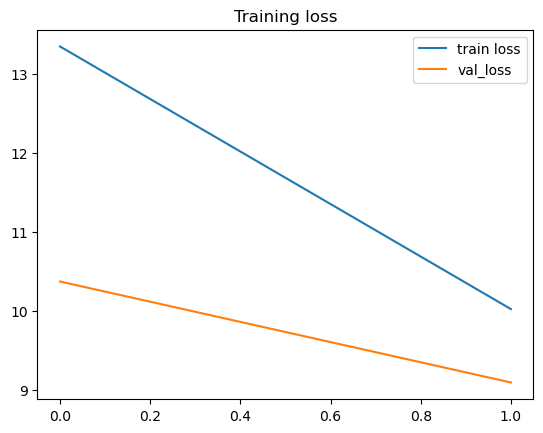

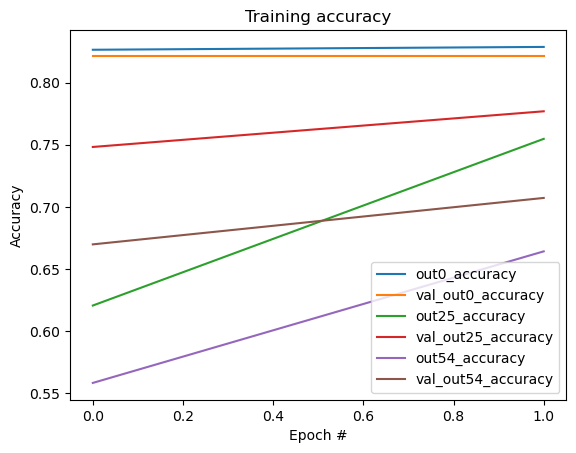

In [19]:
# Show loss curves
plt.figure()
plt.title('Training loss')
plt.plot(hist.epoch, hist.history['loss'], label='train loss')
plt.plot(hist.epoch, hist.history['val_loss'], label='val_loss')
plt.legend()
plt.savefig(save_folder + '/%s Training loss.pdf' %(name), format='pdf')
# plt.show()

plt.figure()
plt.title('Training accuracy')
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
lossNames = ['out0_accuracy', 'out25_accuracy', 'out54_accuracy']
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	plt.plot(hist.epoch, hist.history[l], label=l)
	plt.plot(hist.epoch, hist.history["val_" + l],
		label="val_" + l)
	plt.legend()
plt.savefig(save_folder + '/%s Training acc.pdf' %(name), format='pdf')
plt.show()


In [20]:
evalDict = model.evaluate(data_test,[labels_test[:,iter,:] for iter in range(channel_width)])

69/69 [==============================] - 2s 22ms/step - loss: 9.1224 - out0_loss: 0.0971 - out1_loss: 0.1137 - out2_loss: 0.1462 - out3_loss: 0.1115 - out4_loss: 0.1975 - out5_loss: 0.1152 - out6_loss: 0.1358 - out7_loss: 0.1107 - out8_loss: 0.1441 - out9_loss: 0.1104 - out10_loss: 0.1378 - out11_loss: 0.1059 - out12_loss: 0.1200 - out13_loss: 0.1053 - out14_loss: 0.1241 - out15_loss: 0.1327 - out16_loss: 0.2118 - out17_loss: 0.0992 - out18_loss: 0.1194 - out19_loss: 0.1072 - out20_loss: 0.1179 - out21_loss: 0.0998 - out22_loss: 0.1267 - out23_loss: 0.1034 - out24_loss: 0.1377 - out25_loss: 0.1166 - out26_loss: 0.1252 - out27_loss: 0.1078 - out28_loss: 0.1532 - out29_loss: 0.1085 - out30_loss: 0.1252 - out31_loss: 0.1154 - out32_loss: 0.1219 - out33_loss: 0.1021 - out34_loss: 0.1620 - out35_loss: 0.1093 - out36_loss: 0.1333 - out37_loss: 0.1106 - out38_loss: 0.1239 - out39_loss: 0.1110 - out40_loss: 0.1282 - out41_loss: 0.1214 - out42_loss: 0.1729 - out43_loss: 0.1057 - out44_loss: 0.1

In [21]:
totalA = 0
for i in range(total_channels+1,total_channels+1+total_channels):
    totalA += evalDict[i]

totalA /= total_channels
print(totalA)

0.7618732120417342


In [22]:
# Saving dict of history and evaluation result
with open(save_folder + '/' + 'histDict', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

with open(save_folder + '/' + 'evalDict' + str(totalA), 'wb') as file_pi:
    pickle.dump(evalDict, file_pi)

In [23]:
#uncomment to save model
model.save(save_folder + '/' + name + '_Model')

INFO:tensorflow:Assets written to: template_10/All_channels_test_Model\assets


INFO:tensorflow:Assets written to: template_10/All_channels_test_Model\assets


In [24]:
#Test on test data
true_test_labels = np.argmax(labels_test, axis=-1)
test_predictions = model.predict(data_test)
test_result = np.argmax(test_predictions, axis=-1).T

69/69 [==============================] - 2s 14ms/step


In [25]:
#classification report
class_names = ['Empty channel', 'Wi-Fi', 'Bluetooth']
class_report = classification_report(true_test_labels.flatten(), test_result.flatten(),target_names=class_names)
print(class_report)

with open(save_folder + '/' + 'classReportString', 'wb') as file_pi:
    pickle.dump(class_report, file_pi)

               precision    recall  f1-score   support

Empty channel       0.75      0.97      0.84    107767
        Wi-Fi       0.85      0.75      0.79     33819
    Bluetooth       0.60      0.09      0.16     31977

     accuracy                           0.76    173563
    macro avg       0.73      0.60      0.60    173563
 weighted avg       0.74      0.76      0.71    173563



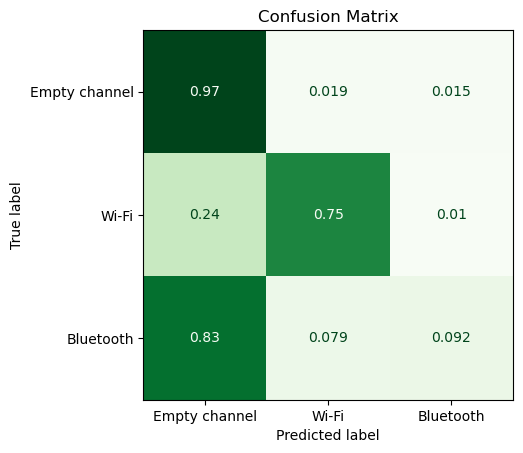

In [26]:
#Confusion matric plot
ConfusionMatrixDisplay.from_predictions(true_test_labels.flatten(), test_result.flatten(),normalize='true',cmap='Greens',colorbar=False,display_labels=class_names)
plt.title('Confusion Matrix')
plt.savefig(save_folder +'/confusion_matrix_'+ name +'.pdf', format='pdf')

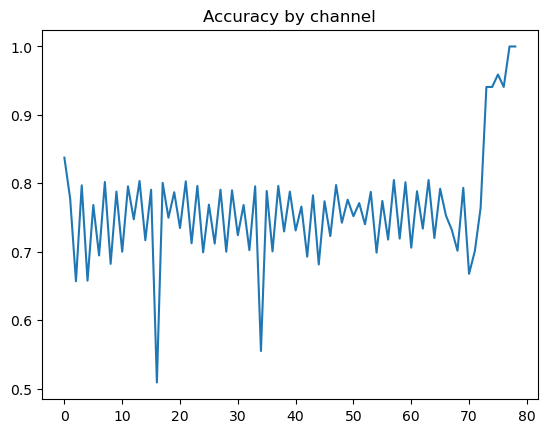

In [27]:
#%matplotlib inline

#accuracy for each channel
plt.plot(evalDict[total_channels+1:total_channels+1+total_channels])
plt.title('Accuracy by channel')
plt.savefig(save_folder +'/acc_by_channel_'+ name +'.pdf', format='pdf')

In [28]:
class_reportDict = classification_report(true_test_labels.flatten(), test_result.flatten(),output_dict=True, target_names=class_names)
for key in class_reportDict:
    try:
        class_reportDict[key]['Samples'] = class_reportDict[key].pop('support')
    except Exception as e:
        print(e)
print(class_reportDict)


'float' object has no attribute 'pop'
{'Empty channel': {'precision': 0.7497028076571157, 'recall': 0.9655831562537697, 'f1-score': 0.8440579804190358, 'Samples': 107767}, 'Wi-Fi': {'precision': 0.8459217539977874, 'recall': 0.7461190455069635, 'f1-score': 0.7928921568627451, 'Samples': 33819}, 'Bluetooth': {'precision': 0.5961499493414387, 'recall': 0.09200362760734278, 'f1-score': 0.1594061551798873, 'Samples': 31977}, 'accuracy': 0.7618732103040394, 'macro avg': {'precision': 0.7305915036654472, 'recall': 0.6012352764560254, 'f1-score': 0.598785430820556, 'Samples': 173563}, 'weighted avg': {'precision': 0.7401608476537439, 'recall': 0.7618732103040394, 'f1-score': 0.7079489686911765, 'Samples': 173563}}


In [29]:
class_reportDict.pop('accuracy')
print(class_reportDict)

{'Empty channel': {'precision': 0.7497028076571157, 'recall': 0.9655831562537697, 'f1-score': 0.8440579804190358, 'Samples': 107767}, 'Wi-Fi': {'precision': 0.8459217539977874, 'recall': 0.7461190455069635, 'f1-score': 0.7928921568627451, 'Samples': 33819}, 'Bluetooth': {'precision': 0.5961499493414387, 'recall': 0.09200362760734278, 'f1-score': 0.1594061551798873, 'Samples': 31977}, 'macro avg': {'precision': 0.7305915036654472, 'recall': 0.6012352764560254, 'f1-score': 0.598785430820556, 'Samples': 173563}, 'weighted avg': {'precision': 0.7401608476537439, 'recall': 0.7618732103040394, 'f1-score': 0.7079489686911765, 'Samples': 173563}}


In [30]:
df = pd.DataFrame(class_reportDict).transpose().round(decimals=3)
dfi.export(df, save_folder + '/' +name + "_ClassReport.png", table_conversion="matplotlib")

In [29]:
#'animated' data prediction check
'''#outcommentted while running batches
%matplotlib qt
fig,ax = plt.subplots(3)

for i in range(20):
    ax[0].images.clear()
    ax[1].images.clear()
    ax[2].images.clear()

    ax[0].imshow(np.reshape(data_test[i],(20,total_channels)))
    ax[0].set_title('Data')

    ax[1].imshow([true_test_labels[i]],vmin=0,vmax=2)
    ax[1].set_title('Label')
    ax[1].axis('off')

    result = model.predict(np.expand_dims(data_test[i], axis=0))
    ax[2].imshow( [[x.argmax() for x in result]] ,vmin=0,vmax=2)
    ax[2].set_title('Predict')
    ax[2].axis('off')
    
    plt.pause(1)
%matplotlib inline
'''

"#outcommentted while running batches\n%matplotlib qt\nfig,ax = plt.subplots(3)\n\nfor i in range(20):\n    ax[0].images.clear()\n    ax[1].images.clear()\n    ax[2].images.clear()\n\n    ax[0].imshow(np.reshape(data_test[i],(20,total_channels)))\n    ax[0].set_title('Data')\n\n    ax[1].imshow([true_test_labels[i]],vmin=0,vmax=2)\n    ax[1].set_title('Label')\n    ax[1].axis('off')\n\n    result = model.predict(np.expand_dims(data_test[i], axis=0))\n    ax[2].imshow( [[x.argmax() for x in result]] ,vmin=0,vmax=2)\n    ax[2].set_title('Predict')\n    ax[2].axis('off')\n    \n    plt.pause(1)\n%matplotlib inline\n"